# Astronomy 499: Assignment 3

In [1]:
import numpy as np
import scipy.constants as const
import matplotlib.pyplot as plt
from astropy import units as u
from astropy.units import cds
cds.enable()
import pandas as pd

## Part 1: Refraction Calculation

### 1a: Determine Necessary Equations

Read the Stone 1996 paper and determine which equations are needed.

In [2]:
latitude = -30.24463 * u.deg
longitude = -70.74942 * u.deg
altitude = 2647 * u.m
p0 = 101325 * u.Pa # sea level air presssure
g = const.g * (u.m/u.s**2)
R0 = 8.31447 * u.J/(u.mol*u.K) # gas constant
T0 = 19. * u.deg_C # typical sea level temperature
lapseRate = -6.5 * (u.deg_C/u.km) # typical rate of change of temperature with altitude
M = 0.0289644 * (u.kg/u.mol) # molar mass of dry air
humidity = 40. # typical humidity at many ovservatory sites


In [3]:
temperature = T0 + (lapseRate * altitude)
temperatureK = temperature.to(u.K, equivalencies = u.temperature())

pressure = (p0 * np.exp((-g * M * altitude) / (R0 * temperatureK))).to(u.Pa)


## 1b: 

Write python functions for calculating each of the quantities needed for calculating refraction. In general, try to write a separate function for each numbered equation in the 1996 paper.

In [4]:
# Equations from 1996 paper

# calculating the water-vapor pressure (mm)
def power_vapor_pressure(temp, RH):
    t = temp.value
    x = np.log(RH/100)
    tdC_numerator = (((t + 238.3)*x) + (17.2694 * t))
    tdC_demoninator = ((t + 238.3) * (17.2694 - x)) - (17.2694 * t)
    tdC = (238.3 * (tdC_numerator/tdC_demoninator)) * u.deg_C
    t_dewpoint_C = tdC.value
    pressure = (4.50874 + (0.341724 * t_dewpoint_C) + (0.0106778 * t_dewpoint_C**2) + (0.184889e-3 * t_dewpoint_C**3) + (0.238294e-5 * t_dewpoint_C**4) + (0.203447e-7 * t_dewpoint_C**5)) * u.cds.mmHg
    return pressure

p_w = (power_vapor_pressure(temperature, humidity)).to(u.cds.mbar)
p_s = pressure.to(u.cds.mbar)

print(f"The water-vapor pressure is {p_w:.2f}.")
print(f"The dry air pressure is {p_s:.2f}.")

The water-vapor pressure is 2.57 mbar.
The dry air pressure is 729.25 mbar.


In [5]:
# Using Equations: 4, 5, 9, 10, 14, 15, 16, 18, 20, 21 + 2

def gammafunction(wavelength, Ps_in, Tinitial, Pw_in):
    T = Tinitial.to(u.K, equivalencies = u.temperature()).value
    
    Ps = 1.333224 * (Ps_in.to(u.Pa).value - Pw_in.to(u.Pa).value)
    Pw = 1.333224 * Pw_in.to(u.Pa).value
    sigma = 1/wavelength.to(u.um).value
    
    Ds = (1 + (Ps * (57.90e-8 - (9.3250e-4/T) + (0.25844/T**2)))) * (Ps/T)
    Dw = (1 + Pw * (1 + 3.7e-4 * Pw) * (-2.37321e-3 + ((2.23366/T)-(710.792/T**2) + (7.75141e4/T**3)))) * (Pw/T)
    term_one = (2371.34 + (683939.7/(130 - sigma**2)) + (4547.3/(38.9 - sigma**2))) * Ds
    term_two = ((6487.31 + (58.058 * sigma**2) - (0.71150 * sigma**4) + (0.08851 * sigma**6))) * Dw
    n = ((term_one + term_two) / (1e8))
    return n

def calc_beta(tin):
    t = tin.value
    beta = 0.001254 * ((273.15 + t)/273.15)
    return beta

def calc_kappa(phi_degrees, height): # 10
    phi = phi_degrees.to(u.rad).value
    h = height.value
    kappa = 1 + (0.005302 * (np.sin(phi)**2)) - (0.00000583 * (np.sin(2 * phi)**2)) - (0.000000315 * h)
    return kappa
    
# Atmospheric refraction
def atm_refraction(wavelength, Ps_in, Tinitial, Pw_in, phi, h, z0):
    gamma = gammafunction(wavelength, Ps_in, Tinitial, Pw_in)
    #gamma = 0.0002102981378048648
    beta = calc_beta(Tinitial)
    kappa = calc_kappa(phi , h)
    
    refraction = (kappa * gamma * (1 - beta) * np.tan(z0.to(u.rad))) - (kappa * gamma * (beta - (gamma / 2)) * (np.tan(z0.to(u.rad))**3))
    
    return refraction
    
    

## Part 2: Applying the Refraction Calculation

### 2a: Total Refraction vs. Wavelength

Use the parameters and plot total refraction as a function of wavelength for a moderate zenith angle (30 degrees) from 300 nm - 1000 nm.

In [6]:
# g-band
gband = pd.read_csv('/Users/audrey/Desktop/throughputs-master/baseline/total_g.dat', delimiter = " ", comment = "#", header=None, skipinitialspace = True)
gband_wavelength = np.array(gband[0]) * u.nm
gband_throughput = np.array(gband[1])

# i-band
iband = pd.read_csv('/Users/audrey/Desktop/throughputs-master/baseline/total_i.dat', delimiter = " ", comment = "#", header=None, skipinitialspace = True)
iband_wavelength = np.array(iband[0]) * u.nm
iband_throughput = np.array(iband[1])


In [7]:
wavelength_values = np.linspace(300, 1000, 100) * u.nm
zin = 30 * u.deg

refraction500 = atm_refraction(500*u.nm, p_s, temperature, p_w, latitude, altitude, zin)
refraction = atm_refraction(wavelength_values, p_s, temperature, p_w, latitude, altitude, zin)

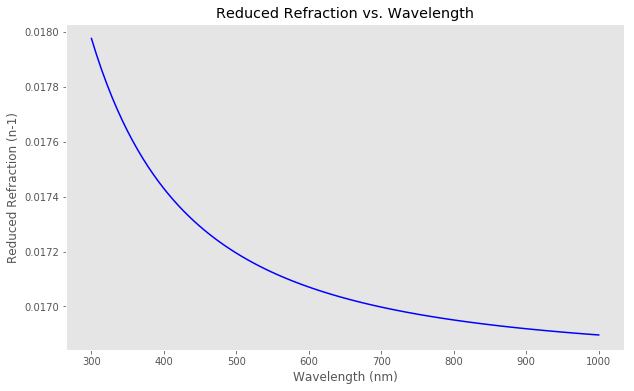

In [8]:
plt.style.use('ggplot')
fig, ax = plt.subplots(1, 1, figsize = (10,6))
plt.plot(wavelength_values, refraction, color = 'b')
ax.set_title('Reduced Refraction vs. Wavelength')
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('Reduced Refraction (n-1)');
ax.grid()

### 2b: 

Use the g- and i-band filter throughputs to calculate maximum DCR within g- and i-bands and plot each as a function of zenith angle from 0 to 65 degrees zenith angle.

In [9]:
zenith_angle = np.linspace(0, 65, 66) * u.deg

# For G-Band
maxthroughput_gband = gband_throughput.max()
maxwavelength_gband = gband_wavelength[np.where(gband_throughput == maxthroughput_gband)]

gthrough_range = np.where(gband_throughput > maxthroughput_gband/2)
print(f'Indices where g-band throughput > half max throughput: {gthrough_range}')
gwavelength_min = gband_wavelength[1056]
print(f'Minimum g-band wavelength = {gwavelength_min}')
gwavelength_max = gband_wavelength[2519]
print(f'Maximum g-band wavelength = {gwavelength_max}')

# Defining g-band wavelength range
grange = np.linspace(gwavelength_min, gwavelength_max, 100)
print(f'\nG-band wavelength range: {gwavelength_min:.2f} < wavelength < {gwavelength_max:.2f}')


Indices where g-band throughput > half max throughput: (array([1056, 1057, 1058, ..., 2517, 2518, 2519]),)
Minimum g-band wavelength = 405.600000000024 nm
Maximum g-band wavelength = 551.9000000000573 nm

G-band wavelength range: 405.60 nm < wavelength < 551.90 nm


In [10]:
# For I-Band
maxthroughput_iband =iband_throughput.max()
maxwavelength_iband = iband_wavelength[np.where(iband_throughput == maxthroughput_iband)]

ithrough_range = np.where(iband_throughput > maxthroughput_iband/2)
print(f'Indices where i-band throughput > half max throughput: {ithrough_range}')
iwavelength_min = iband_wavelength[3918]
print(f'Minimum i-band wavelength = {iwavelength_min}')
iwavelength_max = iband_wavelength[5166]
print(f'Maximum i-band wavelength = {iwavelength_max}')

# Defining i-band wavelength range
irange = np.linspace(iwavelength_min, iwavelength_max, 100)
print(f'\nI-band wavelength range: {iwavelength_min:.2f} < wavelength < {iwavelength_max:.2f}')

Indices where i-band throughput > half max throughput: (array([3918, 3919, 3920, ..., 5164, 5165, 5166]),)
Minimum i-band wavelength = 691.8000000000891 nm
Maximum i-band wavelength = 816.6000000001175 nm

I-band wavelength range: 691.80 nm < wavelength < 816.60 nm


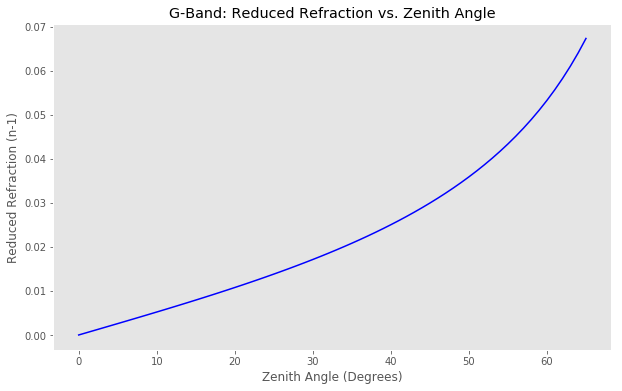

In [11]:
# Max Refraction for G-Band

refraction_gband = atm_refraction(maxwavelength_gband, p_s, temperature, p_w, latitude, altitude, zenith_angle)

# Plot for g-band
fig, ax = plt.subplots(1, 1, figsize = (10,6))
plt.plot(zenith_angle, refraction_gband, color = 'b')
ax.set_title('G-Band: Reduced Refraction vs. Zenith Angle')
ax.set_xlabel('Zenith Angle (Degrees)')
ax.set_ylabel('Reduced Refraction (n-1)');
ax.grid()


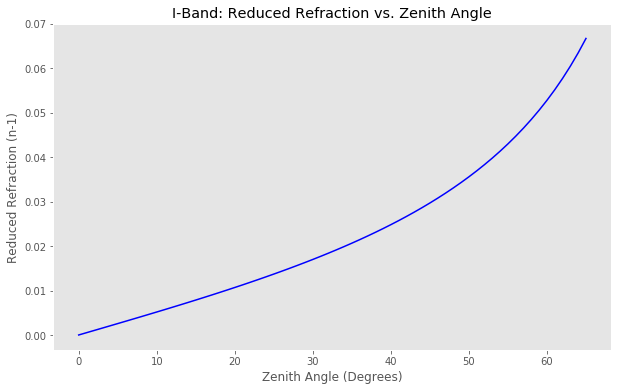

In [12]:
# Max Refraction for I-Band

refraction_iband = atm_refraction(maxwavelength_iband, p_s, temperature, p_w, latitude, altitude, zenith_angle)

# Plot for i-band
fig, ax = plt.subplots(1, 1, figsize = (10,6))
plt.plot(zenith_angle, refraction_iband, color = 'b')
ax.set_title('I-Band: Reduced Refraction vs. Zenith Angle')
ax.set_xlabel('Zenith Angle (Degrees)')
ax.set_ylabel('Reduced Refraction (n-1)');
ax.grid()


## Part 3: Explore the Parameter Space Further

### 3a: Reduced Refraction vs. Temperature

Using the g-band minimum and maximum wavelengths and a 30 degree zenith angle, plot DCR as a function of temperature.

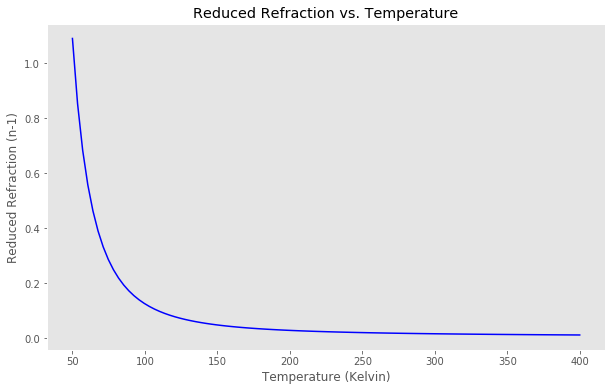

In [13]:
# Define zenith angle
z30 = 30 * u.deg

# Define temperature range
temp = np.linspace(50, 400, 100) * u.K

# Reduced Refraction with Temperature Dependence
greduced_temp = atm_refraction(grange, p_s, temp, p_w, latitude, altitude, z30)

fig, ax = plt.subplots(1, 1, figsize = (10,6))
plt.plot(temp, greduced_temp, color = 'b')
ax.set_title('Reduced Refraction vs. Temperature')
ax.set_xlabel('Temperature (Kelvin)')
ax.set_ylabel('Reduced Refraction (n-1)');
ax.grid()

### 3b: Reduced Refraction vs. Pressure

Plot DCR as a function of pressure.

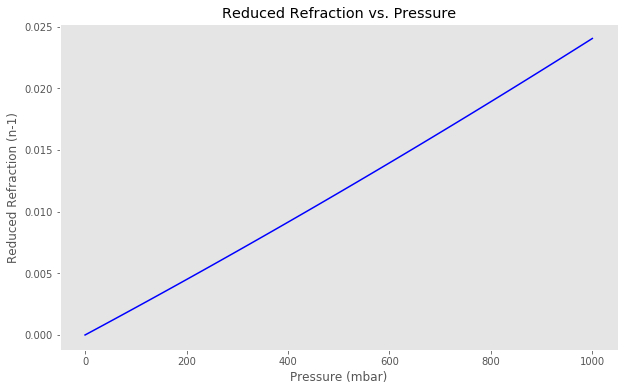

In [14]:
# Pressure range
press_range = np.linspace(0, 1000, 100) * u.cds.mbar

# Reduced Refraction with Pressure Dependence
greduced_press = atm_refraction(maxwavelength_gband, press_range, temperature, p_w, latitude, altitude, z30)

fig, ax = plt.subplots(1, 1, figsize = (10,6))
plt.plot(press_range, greduced_press, color = 'b')
ax.set_title('Reduced Refraction vs. Pressure')
ax.set_xlabel('Pressure (mbar)')
ax.set_ylabel('Reduced Refraction (n-1)');
ax.grid()

### 3c: Reduced Refraction vs. Humidity

Plot DCR as a function of humidity.

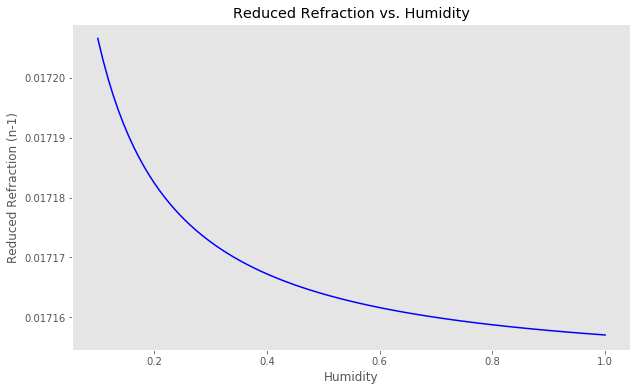

In [15]:
# Humidity range
hum_range = np.linspace(0.1, 1.0, 100)

# New pressure with humidity range
p_w_new = power_vapor_pressure(temperature, hum_range)

# Reduced Refraction with Humidity Dependence
greduced_hum = atm_refraction(maxwavelength_gband, p_s, temperature, p_w_new, latitude, altitude, z30)

fig, ax = plt.subplots(1, 1, figsize = (10,6))
plt.plot(hum_range, greduced_hum, color = 'b')
ax.set_title('Reduced Refraction vs. Humidity')
ax.set_xlabel('Humidity')
ax.set_ylabel('Reduced Refraction (n-1)');
ax.grid()